# NOTES

# IMPORT

In [1]:
from keras import models
from keras import layers
from keras.utils import plot_model
from keras import backend as K
import cv2
from imutils import paths
import progressbar
import imutils
from keras.preprocessing.image import img_to_array
import numpy as np
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.optimizers import SGD
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import shuffle

Using TensorFlow backend.


# DATASET

In [2]:
img_dir = 'C:/Users/Tajr/Desktop/Data/RadonPlus/RadonTechnology/Dev/Deep Learning/Datasets/computervision/Malaria/cell_images/'


## PREPROCESSING

In [3]:
class Preprocessing:
    def __init__(self, width, height, inter=cv2.INTER_AREA, dataFormat=None):
        self.width = width
        self.height = height
        self.inter = inter
        self.dataFormat = dataFormat
        self.load_widget = ['Data Loading: ', progressbar.Percentage(), " ", progressbar.Bar(), " ", progressbar.ETA()]
        
    def getPath(self, img_dir):
        return list(paths.list_images(img_dir))
    
    def load_data(self, img_paths):
        data = []
        labels = []
        
        prog = progressbar.ProgressBar(maxval=len(img_paths), widgets=self.load_widget).start()
        for (i, path) in enumerate(img_paths):
            img = cv2.imread(path)
            img = self.resize(img)
            img = self.img2array(img)
            data.append(img)
            
            label = path.split('/')[-1].split()[0]
            labels.append(label)
            
            prog.update(i)
        
        data = np.array(data).astype('float') / 255.0
        labels = np.array(labels)
        prog.finish()
        
        return (data, labels)
    
    def resize(self, img):
        
        (h, w) = img.shape[:2]
        dh = 0
        dw = 0
        
        # resizing
        if w < h:
            img = imutils.resize(img, width=self.width, inter=self.inter)
            dh = int((img.shape[0]  - self.height) / 2.0)
        else:
            img = imutils.resize(img, height=self.height, inter=self.inter)
            dw = int((img.shape[1] - self.width) / 2.0)
        
        # cropping
        (h, w) = img.shape[:2]
        img = img[dh:h - dh, dw:w - dw]
        
        return cv2.resize(img, (self.width, self.height), interpolation=self.inter)
    
    def img2array(self, img):
        return img_to_array(img, data_format=self.dataFormat)

## INSTANTIATION

In [4]:
preprocessor = Preprocessing(32, 32)

## PATH

In [5]:
imgPaths = shuffle(preprocessor.getPath(img_dir))

## LOADING

In [6]:
(data, targets) = preprocessor.load_data(imgPaths)

Data Loading: 100% |############################################| Time: 0:00:20


In [7]:
data.shape

(27558, 32, 32, 3)

In [8]:
targets.shape

(27558,)

In [9]:
targets[0]

'Parasitized'

## BINARIZATION

In [10]:
lb = LabelBinarizer()
labels = lb.fit_transform(targets)
classNames = lb.classes_

In [11]:
classNames

array(['Parasitized', 'Uninfected'], dtype='<U11')

In [12]:
labels

array([[0],
       [1],
       [1],
       ...,
       [1],
       [0],
       [0]])

## SPLITING

In [13]:
(trainX, test_samples, trainY, test_targets) = train_test_split(data, labels, random_state=42, test_size=0.5)
(testX, valX, testY, valY) =train_test_split(test_samples, test_targets, random_state=42, test_size=0.5)

In [14]:
trainX.shape

(13779, 32, 32, 3)

In [15]:
labels.shape

(27558, 1)

In [16]:
labels[:5]

array([[0],
       [1],
       [1],
       [1],
       [1]])

In [17]:
df = pd.DataFrame(labels)
df.head()

,0
0,0
1,1
2,1
3,1
4,1


# NETWORK

In [18]:
kernel_size = (3, 3)
pool_size = (2, 2)
width = 32
height = 32
depth = 3
classes = 2
input_shape = (width, height, depth)
chan_dim = -1

if K.image_data_format() == 'channels_first':
    input_shape = (depth, width, height)
    chan_dim = 1

In [19]:
model = models.Sequential()
model.add(layers.Conv2D(32, kernel_size, activation='relu', padding='same', input_shape=input_shape))
model.add(layers.BatchNormalization(axis=chan_dim))
model.add(layers.Conv2D(32, kernel_size, padding='same', activation='relu'))
model.add(layers.BatchNormalization(axis=chan_dim))
model.add(layers.MaxPooling2D(pool_size=pool_size))
model.add(layers.Dropout(0.25))
model.add(layers.Conv2D(64, kernel_size, padding='same', activation='relu'))
model.add(layers.BatchNormalization(axis=chan_dim))
model.add(layers.Conv2D(64, kernel_size, padding='same', activation='relu'))
model.add(layers.BatchNormalization(axis=chan_dim))
model.add(layers.MaxPooling2D(pool_size=pool_size))
model.add(layers.Dropout(0.25))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.BatchNormalization(axis=chan_dim))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)       

## ARCHITECTURE

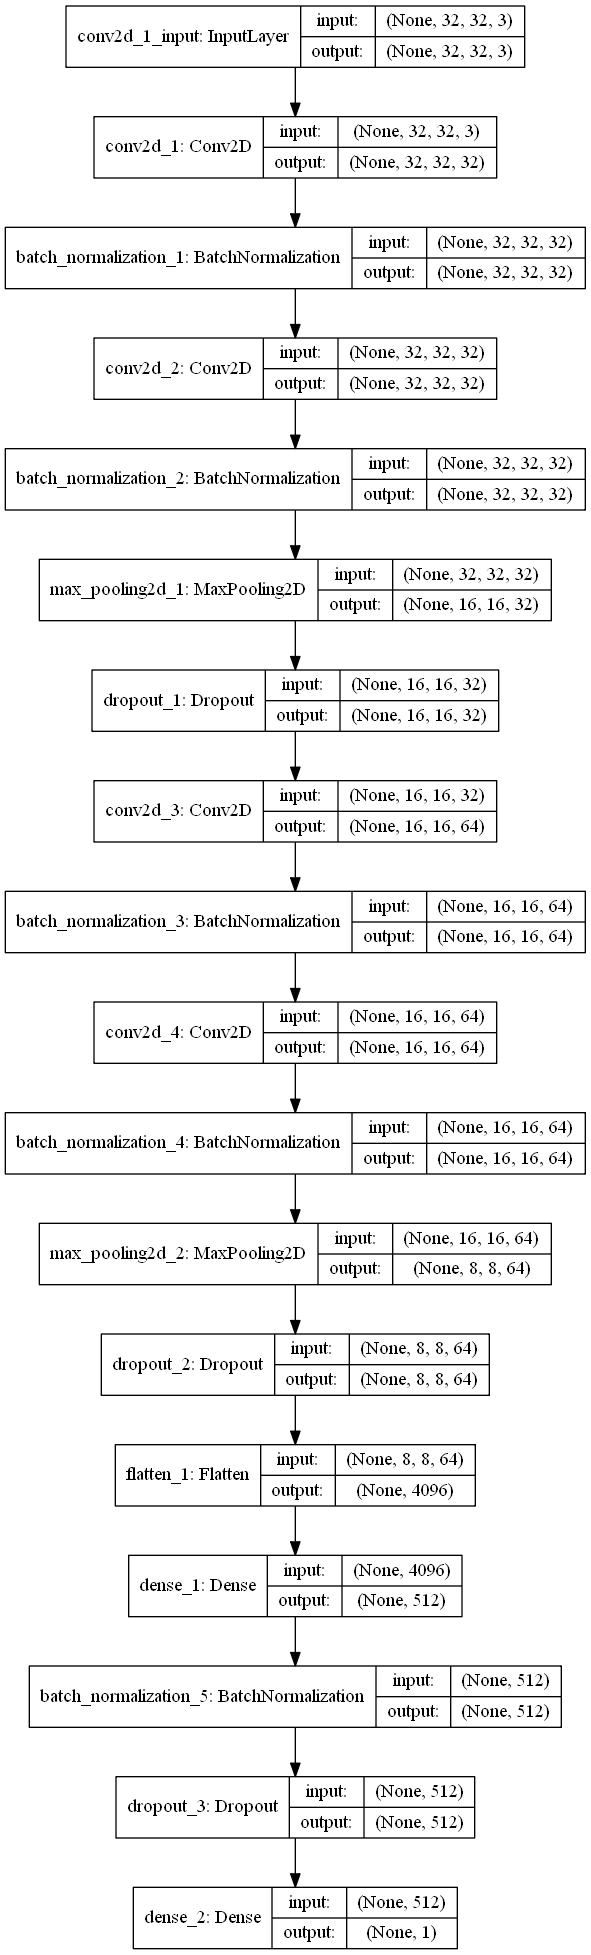

In [20]:
plot_model(model, to_file='serialized/architecture/architecture.png', show_shapes=True)

# TRAINING MULTIPLE MODELS

In [ ]:
num_models = 5

def stepFunc(predictions):
    preds = list()
    
    for p in predictions:
        if p > 0.5:
            p = 1
            preds.append(p)
        else:
            p = 0
            preds.append(p)
    
    return preds

progress = progressbar.ProgressBar(maxval=num_models, widgets=['Training: ', progressbar.Percentage(), ' ', progressbar.Bar(), ' ', progressbar.ETA()]).start()
for i in np.arange(0, num_models):
    
    print()
    print('[INFO] training model {}/{}'.format(i + 1, num_models))
    print()
    # compile
    opt = SGD(lr=0.01, decay=0.01/100, momentum=0.9, nesterov=True)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['acc'])
    
    # train
    history = model.fit(trainX, trainY, epochs=100, batch_size=32, validation_data=(valX, valY))
    
    # save model to disk
    model.save('serialized/model/model_{}.model'.format(i + 1))
    
    # predict
    predictions = model.predict(testX, batch_size=32)
    preds = stepFunc(predictions)
    
    report= classification_report(testY, preds, target_names=classNames)
    
    # save classification report
    path = str('serialized/report/model_{}.txt'.format(i + 1))
    f = open(path, 'w')
    f.write(report)
    f.close()
    
    # save plots
    path = str('serialized/plot/model_{}'.format(i + 1))
    plt.style.use('ggplot')
    plt.plot(np.arange(0, 100), history.history['acc'], label='Train accuracy')
    plt.plot(np.arange(0, 100), history.history['val_acc'], label='Validation accuracy')
    plt.plot(np.arange(0, 100), history.history['loss'], label='Train Loss')
    plt.plot(np.arange(0, 100), history.history['val_loss'], label='Validation Loss')
    plt.title('Train Process')
    plt.xlabel('Epochs')
    plt.ylabel('Acc/Loss')
    plt.legend()
    plt.savefig(path)
    plt.close()
    progress.update(i)

progress.finish()
    


[INFO] training model 1/5

Train on 13779 samples, validate on 6890 samples
Epoch 1/100
13779/13779 [==============================] - 35s 3ms/step - loss: 0.4463 - acc: 0.7943 - val_loss: 0.4116 - val_acc: 0.8247
Epoch 2/100
13779/13779 [==============================] - 31s 2ms/step - loss: 0.2121 - acc: 0.9225 - val_loss: 0.2493 - val_acc: 0.9097
Epoch 3/100
13779/13779 [==============================] - 32s 2ms/step - loss: 0.1817 - acc: 0.9336 - val_loss: 0.2079 - val_acc: 0.9238
Epoch 4/100
13779/13779 [==============================] - 32s 2ms/step - loss: 0.1819 - acc: 0.9357 - val_loss: 0.7269 - val_acc: 0.5081
Epoch 5/100
13779/13779 [==============================] - 31s 2ms/step - loss: 0.1638 - acc: 0.9415 - val_loss: 0.1921 - val_acc: 0.9303
Epoch 6/100
13779/13779 [==============================] - 31s 2ms/step - loss: 0.1504 - acc: 0.9448 - val_loss: 0.3223 - val_acc: 0.8772
Epoch 7/100
13779/13779 [==============================] - 31s 2ms/step - loss: 0.1474 - acc: 0

# PLOTING

# EVALUATION

# PREDICTION

# SUMMARY